In [13]:
#Import standard python libraries
%matplotlib inline
import math
import random
import scipy
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
# Import required Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ, BasicAer
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.input import ClassificationInput
from qiskit.aqua import run_algorithm, QuantumInstance
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.feature_maps import SecondOrderExpansion

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

In [6]:
# Loading your IBM Q account(s)
IBMQ.load_accounts()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/utils/deprecation.py:53: DeprecationWarning: IBMQ.load_accounts() is being deprecated. Please use IBM Q Experience v2 credentials and IBMQ.load_account() (note the singular form) instead. You can find the instructions to make the updates here: 
https://github.com/Qiskit/qiskit-ibmq-provider#updating-to-the-new-ibm-q-experience
  DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:483: DeprecationWarning: Calling IBMQ.load_accounts() with v2 credentials. This is provided for backwards compatibility and may lead to unexpected behaviour when mixing v1 and v2 account credentials.
  'v1 and v2 account credentials.', DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


In [7]:
#Number of customer Datapoints
customer_size = 100# , 250, 1000
#Dimension of the feature-map
feature_dim = 3

In [8]:
#Input Test Data, columns: Age, Annual Income, Annual Spend
test_input_orig = eval(open('kyc-input-test.txt', 'r').read())

print("Length of test_input_orig for class \"G\" = ", len(test_input_orig['G']))
print("Length of test_input_orig for class \"B\" = ", len(test_input_orig['B']))

Length of test_input_orig for class "G" =  82
Length of test_input_orig for class "B" =  113


In [9]:
#Input Training Data, columns: Age, Annual Income, Annual Spend
training_input_orig = eval(open('kyc-input-training.txt', 'r').read())

In [10]:
import random
print("before: " , training_input_orig['G'][10])
print("before: " , test_input_orig['G'][80])
print("before: " , training_input_orig['B'][13])
print("before: " , test_input_orig['B'][13])

#Shuffling the index of the training and test data
random.shuffle(training_input_orig['G'] )
random.shuffle(training_input_orig ['B'] )

random.shuffle(test_input_orig ['G'] ) 
random.shuffle(test_input_orig ['B'] ) 

print("Length of training_input_orig for class \"G\" = ", len(training_input_orig['G']))
print("Length of training_input_orig for class \"B\" = ", len(training_input_orig['B']))
print("after: " , training_input_orig['G'][10])
print("after: " , test_input_orig['G'][80])

print("after: " , training_input_orig['B'][13])
print("after: " , test_input_orig['B'][13])

before:  [46.0, 1587261.9619999998, 157486.6701]
before:  [43.0, 3970797.877, 385877.2086]
before:  [79.0, 2504863.0, 872129.105]
before:  [63.0, 5454359.826, 737848.9225]
Length of training_input_orig for class "G" =  373
Length of training_input_orig for class "B" =  415
after:  [43.0, 3180307.877, 434302.43200000003]
after:  [22.0, 592800.1431, 76117.5846]
after:  [68.0, 927650.0, 114587.5833]
after:  [87.0, 4376718.0, 499733.51]


In [11]:
#this function returns num (e.g. = 250) records
def getData_test1(num):
    train_num = math.ceil(num/2)
    test_num = math.ceil((0.2 * num)/2)
    training_input = dict()
    test_input = dict()
    training_input ['B']  = random.sample(training_input_orig['B'], k=train_num)
    training_input ['G']  = random.sample(training_input_orig['G'], k=train_num)

    test_input ['B']  = random.sample(test_input_orig['B'], k=test_num)
    test_input ['G']  = random.sample(test_input_orig['G'], k=test_num)

    return training_input, test_input

In [14]:
#Get the data equal to customer_size from the training and test input
training_input,test_input =  getData_test1(customer_size)
print("Length of training_input for class \"G\" = ", len(training_input['G']))
print("Length of training_input for class \"B\" = ", len(training_input['B']))

print("Length of test_input for class \"G\" = ", len(test_input['G']))
print("Length of test_input for class \"B\" = ", len(test_input['B']))

Length of training_input for class "G" =  50
Length of training_input for class "B" =  50
Length of test_input for class "G" =  10
Length of test_input for class "B" =  10


In [46]:
#Class Labels
class_labels = ['B', 'G']

extra_test_data =  {'B': [[81,1628719.000,231448.346],
[52,1012073.131,237833.587],
[78,622463.000,69007.173],
[68,2061966.000,361879.305],
[63,121815.000,30453.750],
[71,1147963.000,208783.802],
[77,1387962.000,248983.635],
[78,1055105.000,154584.070],
[81,4271902.000,488029.057],
[54,3506547.520,595905.533]], 

'G': [[43,4950640.877,1119211.757],
[44,5531133.572,535139.591],
[20,1752079.448,617005.439],
[19,1001347.101,121885.720],
[43,4148821.877,705104.135],
[44,4245370.572,721128.983],
[23,2323861.990,402364.530],
[29,1518581.075,537459.954],
[44,3666225.572,499297.756],
[24,1233446.838,177070.112]] }

datapoints, class_to_label = split_dataset_to_data_and_labels(extra_test_data)
print(class_to_label)
print(datapoints)

{'B': 0, 'G': 1}
[array([[8.10000000e+01, 1.62871900e+06, 2.31448346e+05],
       [5.20000000e+01, 1.01207313e+06, 2.37833587e+05],
       [7.80000000e+01, 6.22463000e+05, 6.90071730e+04],
       [6.80000000e+01, 2.06196600e+06, 3.61879305e+05],
       [6.30000000e+01, 1.21815000e+05, 3.04537500e+04],
       [7.10000000e+01, 1.14796300e+06, 2.08783802e+05],
       [7.70000000e+01, 1.38796200e+06, 2.48983635e+05],
       [7.80000000e+01, 1.05510500e+06, 1.54584070e+05],
       [8.10000000e+01, 4.27190200e+06, 4.88029057e+05],
       [5.40000000e+01, 3.50654752e+06, 5.95905533e+05],
       [4.30000000e+01, 4.95064088e+06, 1.11921176e+06],
       [4.40000000e+01, 5.53113357e+06, 5.35139591e+05],
       [2.00000000e+01, 1.75207945e+06, 6.17005439e+05],
       [1.90000000e+01, 1.00134710e+06, 1.21885720e+05],
       [4.30000000e+01, 4.14882188e+06, 7.05104135e+05],
       [4.40000000e+01, 4.24537057e+06, 7.21128983e+05],
       [2.30000000e+01, 2.32386199e+06, 4.02364530e+05],
       [2.900

In [15]:
#Creates the entangled feature map of dimension 'depth'
feature_map = SecondOrderExpansion(feature_dimension=feature_dim, depth=2, entanglement='linear')
print(feature_map)
#Creates the QSVM object to run and obtain results subsequently
qsvm = QSVM(feature_map, training_input, test_input)
print(feature_dim)

Due to the limited entangler_map, ZIZ is skipped.


3


In [16]:
#Obtain a list of available IBMQ devices
from qiskit import IBMQ
IBMQ.load_accounts()
print("Available backends:")
IBMQ.backends()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/utils/deprecation.py:53: DeprecationWarning: IBMQ.load_accounts() is being deprecated. Please use IBM Q Experience v2 credentials and IBMQ.load_account() (note the singular form) instead. You can find the instructions to make the updates here: 
https://github.com/Qiskit/qiskit-ibmq-provider#updating-to-the-new-ibm-q-experience
  DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:483: DeprecationWarning: Calling IBMQ.load_accounts() with v2 credentials. This is provided for backwards compatibility and may lead to unexpected behaviour when mixing v1 and v2 account credentials.
  'v1 and v2 account credentials.', DeprecationWarning)


Available backends:


/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:548: DeprecationWarning: IBMQ.backends() is being deprecated. Please use IBMQ.get_provider() to retrieve a provider and AccountProvider.backends() to find its backends.
  DeprecationWarning)


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [17]:
#Select a IBMQ device
device = IBMQ.get_backend('ibmq_qasm_simulator', hub=None)
print (device)

ibmq_qasm_simulator


/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:595: DeprecationWarning: IBMQ.get_backend() is being deprecated. Please use IBMQ.get_provider() to retrieve a provider and AccountProvider.get_backend("name") to retrieve a backend.
  DeprecationWarning)


In [19]:
#Create a quantum instance on the device to run the algorithm object, in this case a qsvm object
#The seed to use in the algorithm
seed = 1059
quantum_instance = QuantumInstance(device, shots=1024, seed_transpiler=seed)
print(quantum_instance)

The skip Qobj validation does not work for IBMQ provider. Disable it.



Qiskit Terra version: 0.10.0
Backend: 'ibmq_qasm_simulator (<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'ccx', 'swap', 'unitary', 'initialize', 'kraus'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 1059, 'optimization_level': None}
RunConfig(max_credits=10, shots=1024)
{'timeout': None, 'wait': 5}
{}
{}
Measurement mitigation: None


In [20]:
from timeit import default_timer as timer
from datetime import timedelta
start = timer()
print("timedelta: " , timedelta(seconds=start))

timedelta:  11 days, 21:17:26.805679


In [21]:
#Run the quantum algorithm on the quantum instance
result = qsvm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])
end = timer()
print("timedelta: " , timedelta(seconds=end-start))

testing success ratio:  0.5
timedelta:  0:37:06.194898


In [53]:
#print and investigate the result
result

{'kernel_matrix_training': array([[1.        , 0.04003906, 0.07714844, ..., 0.0078125 , 0.06640625,
         0.37109375],
        [0.04003906, 1.        , 0.06835938, ..., 0.27734375, 0.35546875,
         0.06640625],
        [0.07714844, 0.06835938, 1.        , ..., 0.08105469, 0.2421875 ,
         0.23144531],
        ...,
        [0.0078125 , 0.27734375, 0.08105469, ..., 1.        , 0.51171875,
         0.17773438],
        [0.06640625, 0.35546875, 0.2421875 , ..., 0.51171875, 1.        ,
         0.45019531],
        [0.37109375, 0.06640625, 0.23144531, ..., 0.17773438, 0.45019531,
         1.        ]]),
 'svm': {'alphas': array([2.55910953, 2.50297023, 2.47415817, 0.76255861, 0.58279924,
         1.1487291 , 0.90163859, 1.07858806, 1.6149712 , 0.76818444,
         0.21275352, 2.0272394 , 1.56299904, 1.05019004, 2.52015369,
         1.69119825, 1.53824696, 1.69699069, 3.34391945, 1.58085075,
         0.76172848, 0.85599077, 1.32138845, 0.67313045, 0.41103281,
         0.02293453, 

kernel matrix during the training:


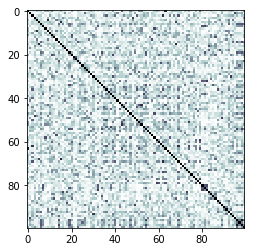

In [54]:
import numpy as np 
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()

In [55]:
#A function created to programatically create the hyperplane to diaplay in the plot
#This is being done as the QSVM Result object does not give us the hyperplane
def getMinMax_XY(training_input):  
    ages_g = np.array([])
    ages_b =np.array([])
    gross_g = np.array([])
    gross_b =np.array([])
    spend_g = np.array([])
    spend_b =np.array([])
    for k in training_input['G']:
        #print(k[0])
        ages_g = np.append(ages_g, k[0])
        gross_g = np.append(gross_g, k[1])
        spend_g = np.append(gross_g, k[2])
    for k in training_input['B']:
        ages_b = np.append(ages_b, k[0])
        gross_b = np.append(gross_b, k[1])
        spend_b = np.append(gross_g, k[2])
    # green is good < 50 
    green_x_max = max(ages_g)
    #blue is bad > 50 age
    blue_x_min = min(ages_b)
    
    green_y_min = min(gross_g)
    green_y_max = max(gross_g)
    
    blk_z_min = min(spend_g)
    blk_z_max = max(spend_b)
    return green_x_max, blue_x_min, green_y_max, green_y_min,blk_z_min, blk_z_max

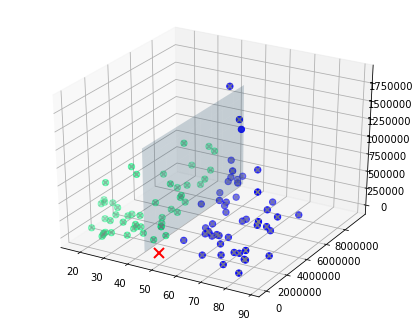

In [56]:
#Visualise the classified points
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import axes3d

trainingDataPoints = np.vstack((np.array(training_input['B']), np.array(training_input['G'])))
trainingLabels = [0]*len(training_input['B']) + [1]*len(training_input['G'])
green_x_max, blue_x_min, green_y_max, green_y_min , blk_z_min, blk_z_max = getMinMax_XY(training_input)

y_mean = green_y_min
x_mean = green_x_max
z_mean=blk_z_min

fig=plt.figure(figsize=(16,12.5))
ax=fig.add_subplot(2,2,1,projection="3d")
#Points for the line dividing the classes
xs = [result['svm']['bias'][0],green_x_max,blue_x_min]

ys = [blue_x_min,green_y_min,green_y_max]
zs = [5617732.962, 172383.90600000002, 5617732.90600000002] #[green_y_min, blk_z_min, blk_z_max]
ax.scatter(trainingDataPoints[:, 0], trainingDataPoints[:, 1],trainingDataPoints[:, 2], c=trainingLabels, s=40, cmap='winter', label='Data Points')
#Plot the support vectors
ax.scatter(np.array(result['svm']['support_vectors'][:,0]),np.array(result['svm']['support_vectors'][:,1]),np.array(result['svm']['support_vectors'][:,2]), s=25, c='grey', marker="x", label='Support Vectors')
#Plot the mean point
ax.plot([x_mean], [y_mean], 'x', color='red', markeredgewidth=2, markersize=10)

#Draw hyperplane
y = np.linspace(0,9500000,10)
z = np.linspace(0,1450000,10)
Y, Z = np.meshgrid(y, z)
xs = np.array([44]*100)
X=xs.reshape(Z.shape)
ax.plot_surface(X, Y,Z, alpha=0.2)

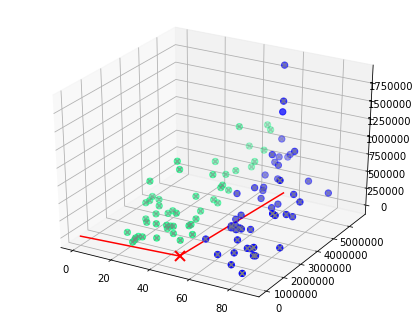

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import axes3d

fig=plt.figure(figsize=(16,12.5))
ax=fig.add_subplot(2,2,1,projection="3d")
#Points for the line dividing the classes
green_x_max, blue_x_min, green_y_max, green_y_min , blk_z_min, blk_z_max = getMinMax_XY(training_input)
xs = [result['svm']['bias'][0],green_x_max,blue_x_min]

ys = [blue_x_min,green_y_min,green_y_max]
zs = [green_y_min, blk_z_min, blk_z_max]
ax.scatter(trainingDataPoints[:, 0], trainingDataPoints[:, 1],trainingDataPoints[:, 2], c=trainingLabels, s=40, cmap='winter', label='Data Points')
#Plot the support vectors
ax.scatter(np.array(result['svm']['support_vectors'][:,0]),np.array(result['svm']['support_vectors'][:,1]),np.array(result['svm']['support_vectors'][:,2]), s=25, c='grey', marker="x", label='Support Vectors')
#Plot the mean point
ax.plot([x_mean], [y_mean], 'x', color='red', markeredgewidth=2, markersize=10)
#Plot the class-dividing line
ax.plot(xs, ys, color='red')
plt.show()

In [58]:
len(trainingDataPoints[:, 0])

100

In [59]:
result['svm']['bias'][0]

0.11425697146513179

ValueError: too many values to unpack (expected 4)

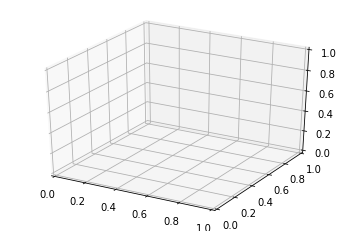

In [60]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig2 = plt.figure()
#ax1 = fig2.add_subplot(111)
ax = plt.gca(projection="3d")

#Points for the line dividing the classes
green_x_max, blue_x_min, green_y_max, green_y_min  = getMinMax_XY(training_input)
xs = [result['svm']['bias'][0],green_x_max,blue_x_min]

ys = [blue_x_min,green_y_min,green_y_max]
y_mean = green_y_min
x_mean = green_x_max
#Calculate slope
m = y_mean/(x_mean-result['svm']['bias'][0])
#m = 2500000.0/(48-result['svm']['bias'][0])

#Visualization of Data
#Reshape data - stack the data and labels separately
trainingDataPoints = np.vstack((np.array(training_input['B']), np.array(training_input['G'])))
trainingLabels = [0]*len(training_input['B']) + [1]*len(training_input['G'])

#Plot the training set
y_mean = green_y_min
x_mean = green_x_max
# y_mean = np.mean(trainingDataPoints[:, 1])
# print(y_mean)
# x_mean = np.mean(trainingDataPoints[:, 0])
# print(x_mean)

x,y,z = [1,1.5,3],[1,2.4,3],[3.4,1.4,1]
ax.scatter(x,y,z, c='r',s=100)
ax.plot(x,y,z, color='r')

plt.show()

ax1.scatter(trainingDataPoints[:, 0], trainingDataPoints[:, 1],trainingDataPoints[:, 2] , c=trainingLabels, s=40, cmap='winter', label='Data Points')
#Plot the support vectors
ax1.scatter(np.array(result['svm']['support_vectors'][:,0]),np.array(result['svm']['support_vectors'][:,1]), s=25, c='grey', marker="x", label='Support Vectors')
#Plot the mean point
ax1.plot([x_mean], [y_mean], 'x', color='red', markeredgewidth=2, markersize=10)
#Plot the class-dividing line
ax1.plot(xs, ys, color='red')
plt.legend(loc='upper left');
plt.show()

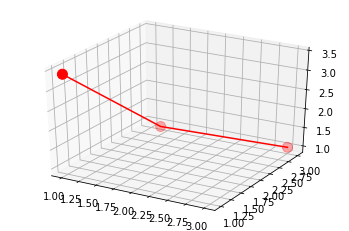

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ax = plt.gca(projection="3d")
x,y,z = [1,1.5,3],[1,2.4,3],[3.4,1.4,1]
ax.scatter(x,y,z, c='r',s=100)
ax.plot(x,y,z, color='r')

plt.show()